In [1]:
import matplotlib.pyplot as plt
import numpy as np
from   numpy.linalg import inv
import numpy.random as npr
from   pypolyagamma import PyPolyaGamma
from scipy.stats import multivariate_normal

from heapq import heappush, heappop

import matplotlib.cm as cm
from tqdm import tqdm
import polars as pl

import geopandas as gpd

from shapely.geometry import Point, Polygon
from shapely import wkt

import pandas as pd
import statsmodels.api as sm
import scipy
import scipy.optimize as opt
import seaborn as sns

from pyproj import Transformer

from bayesian_statistics.utils_2 import *
import japanize_matplotlib

from keplergl import KeplerGl

from typing import Tuple

In [2]:
df_obsedian = pl.read_csv("../data/obsedian_gdf.csv", schema_overrides={"No.": str})

In [3]:
time_period_dict = {
    '早期末〜前期初頭': 0, 
    '後期中葉〜後葉': 3,
    '中期末葉〜後期初頭': 2,
    '早期〜後期': 0,
    '中期後葉〜後期初頭': 2,
    '中期中葉': 2,
    '前期後葉〜中期前葉': 1,
    '早期末': 0,
    '晩期中葉': 4,
    '後期中葉〜晩期前葉': 3,
    '早期〜晩期': 2,  # 例外的に中期
    '中期前葉〜後葉': 2,
    '中期後葉主体': 2,
    '後期末〜晩期': 3,
    '後期前葉〜中葉': 3,
    '晩期終末〜弥生前期末': 4,
    '晩期前葉': 4,
    '前期末葉〜中期初頭': 1,
    '中期初頭': 2,
    '早期': 0,
    '早期中葉〜後葉': 0,
    '後期後葉〜晩期前葉': 3,
    '後期前葉': 3,
    '前期中葉': 1,
    '後期〜晩期': 3,
    '後期前葉〜晩期前葉': 3,
    '早期後葉': 0,
    '後期中葉〜晩期中葉': 3,
    '中期前葉': 2,
    '晩期': 4,
    '前期中葉〜後葉': 1,
    '早期前葉': 0,
    '後期初頭': 3,
    '中期後葉': 2,
    '後期後葉〜晩期初頭': 3,
    '中期後葉〜後期前葉': 2,
    '晩期前葉〜中葉': 4,
    '後期中葉〜晩期初頭': 3,
    '早期中葉': 0,
    '中期後葉〜中期末葉': 2,
    '草創期': 0,
    '前期後葉': 1,
    '後期後葉': 3,
    '中期': 2,
    '後期初頭〜前葉': 3,
    '中期中葉〜後葉': 2,
    '後期中葉': 3,
    '晩期末葉': 4,
    '前期': 1,
    '晩期〜弥生中期前葉': 4,
    '草創期〜早期前葉': 0,
    '前期末葉': 1,
    '前期末葉〜中期前葉': 1,
    '中期初頭〜前葉': 2,
    '後期中葉〜後期後葉': 3,
    '中期前葉〜中葉': 2,
    '前期前葉': 1,
    '後期初頭〜後葉': 3,
    '後期初頭〜後期前葉': 3,
    '早期後葉〜末葉': 0,
    '草創期後半': 0,
    '早期末葉': 0,
    '前期初頭': 1
}

time_period_name = {
    0: "早期・早々期",
    1: "前期",
    2: "中期",
    3: "後期",
    4: "晩期"
}

origin_order = ["神津島", "信州", "箱根", "高原山", "その他"]

# 産地のカラム名と、産地のカテゴリーの定義
origin_columns = ["高原山", "和田峠", "男女倉", "諏訪", "蓼科", "神津島", "箱根", "天城", "その他", "不明"]

origin_dict = {
    "高原山": "高原山",
    "和田峠": "信州",
    "男女倉": "信州",
    "諏訪": "信州",
    "蓼科": "信州",
    "神津島": "神津島",
    "箱根": "箱根",
    "天城": "箱根",
    "その他": "その他", 
    "不明": "その他"
}

In [4]:
# "時期名"カラムのユニークな値を確認

df_obsedian["時期名"].unique()

df_obsedian.select(
    pl.col("時期名").str.split("(").list.get(0)
).unique().to_numpy().squeeze()


array(['後期中葉〜後期後葉', '早期〜後期', '後期初頭', '後期中葉〜晩期前葉', '中期後葉主体', '後期後葉〜晩期前葉',
       '晩期末葉', '前期前葉', '中期末葉〜後期初頭', '中期前葉〜後葉', '晩期中葉', '草創期', '後期前葉〜晩期前葉',
       '中期中葉〜後葉', '中期後葉〜後期初頭', '中期前葉〜中葉', '前期末葉〜中期前葉', '後期中葉',
       '晩期終末〜弥生前期末', '早期末〜前期初頭', '早期〜晩期', '中期後葉〜後期前葉', '後期初頭〜前葉', '前期初頭',
       '早期後葉〜末葉', '前期中葉〜後葉', '前期末葉〜中期初頭', '中期初頭〜前葉', '後期後葉〜晩期初頭',
       '晩期前葉〜中葉', '後期末〜晩期', '早期中葉〜後葉', '早期末葉', '前期', '後期前葉', '晩期前葉',
       '後期後葉', '中期中葉', '前期後葉', '後期〜晩期', '後期前葉〜中葉', '後期中葉〜晩期初頭', '早期前葉',
       '早期末', '中期', '晩期', '晩期〜弥生中期前葉', '前期中葉', '後期初頭〜後期前葉', '草創期後半',
       '前期後葉〜中期前葉', '早期中葉', '早期', '後期中葉〜晩期中葉', '中期後葉〜中期末葉', '後期初頭〜後葉',
       '早期後葉', '中期初頭', '後期中葉〜後葉', '中期後葉', '草創期〜早期前葉', '中期前葉', '前期末葉'],
      dtype=object)

- 時期の分け方
    - 早々期、早期
    - 前期
    - 中期
    - 後期
    - 晩期
        - 晩期は後期とセットでも良い
  - 早期〜晩期(五領ヶ台Ⅱ〜阿玉台前半主体)は中期〜前期→中期
  - 早期〜後期(条痕文系が6割程度)は早期〜早期後葉→早期

In [5]:
# No.カラムのうち、int型に変換できない値を確認
max_num = (
    df_obsedian
        .filter(pl.col("No.") != "弥9")
        .select(pl.col("No.").cast(pl.Int64))
        .max()
        .to_numpy().squeeze().item()
)

df_obsedian = (
    df_obsedian
        .with_columns(
           [
               (
                   pl.col("時期名")
                   .str.split("(").list.get(0)
                   .replace(time_period_dict).cast(pl.Int64)
                   .alias("時期")
               ), 
               (
                   pl.col("No.")
                   .replace({"弥9": max_num + 1}).cast(pl.Int64)
                   .alias("No.") 
               )
           ]
        )
)

# 黒曜石ごとのdfを作成

def expand_obsidian_data(df):
    # 産地のカラムを定義
    
    # 産地以外のカラムを特定
    other_columns = [col for col in df.columns if col not in origin_columns + ["その他(地名)"]]
    
    # 変換実行
    long_df = df.melt(
        id_vars=other_columns,  # 産地以外のカラムはそのまま保持
        value_vars=origin_columns,  # 産地のカラムを縦持ちに変換
        variable_name="産地",  # 新しい産地カラムの名前
        value_name="点数"  # 数値を持つカラムの名前
    )
    
    # 点数が0より大きい行だけを保持
    long_df = long_df.filter(pl.col("点数") > 0)
    
    # 点数の数だけのリストを作成し、それをexplode
    long_df = long_df.with_columns([
        pl.col("点数").cast(pl.Int64).map_elements(lambda x: [1] * x).alias("points_list")
    ])
    
    # リストをexplodeして各行を複製
    result = long_df.explode("points_list")
    
    # 不要なカラムを削除
    result = result.drop(["点数", "points_list"])
    
    return result


# 産地以外のカラムを特定
other_columns = [col for col in df_obsedian.columns if col not in origin_columns + ["その他(地名)"]]

df_result = (
    df_obsedian
        .unpivot(
            index=other_columns,  # 産地以外のカラムはそのまま保持
            on=origin_columns,  # 産地のカラムを縦持ちに変換
            variable_name="産地",  # 新しい産地カラムの名前
            value_name="点数"  # 数値を持つカラムの名前
        )
        .filter(pl.col("点数") > 0)
        .with_columns([
            pl.col("点数").cast(pl.Int64).map_elements(lambda x: [1] * x, return_dtype=list).alias("points_list")
        ])
        .explode("points_list")
        .drop(["点数", "points_list"])
        .with_columns([
            pl.col("産地").replace(origin_dict).alias("産地カテゴリ")
        ])
)

df_sites = (
    df_result
        .group_by(["遺跡名", "緯度", "経度"])
        .first()
        .drop(["No.", "時期名", "時期", "産地", "産地カテゴリ", "合計", "備考"])
        .sort(pl.col("経度"), pl.col("緯度"), pl.col("遺跡名"))
        # 遺跡にIDを割り振る
        .with_row_index()
        .with_columns([
            pl.col("index").cast(pl.Int64).alias("遺跡ID")
        ])
        .drop("index")
)

# 遺跡IDをdf_resultに戻す
df_result = df_result.join(
    df_sites.drop(["メッシュコード", "都道府県", "geometry"]), 
    on=["遺跡名", "緯度", "経度"]
).drop(["No.", "遺跡名", "メッシュコード", "都道府県", "合計"])


# 産地カテゴリ、時期別の、黒曜石の数のヒートマップ

In [6]:
df_result.group_by(["産地カテゴリ", "時期"]).len().pivot(on="産地カテゴリ", index="時期", values="len").sort("時期").to_pandas().set_index("時期")

,箱根,高原山,信州,神津島,その他
時期,,,,,
0,90,15,342,1019,171
1,111,20,1690,2471,252
2,442,128,4626,10277,1244
3,596,585,2998,1189,578
4,88,78,590,400,70


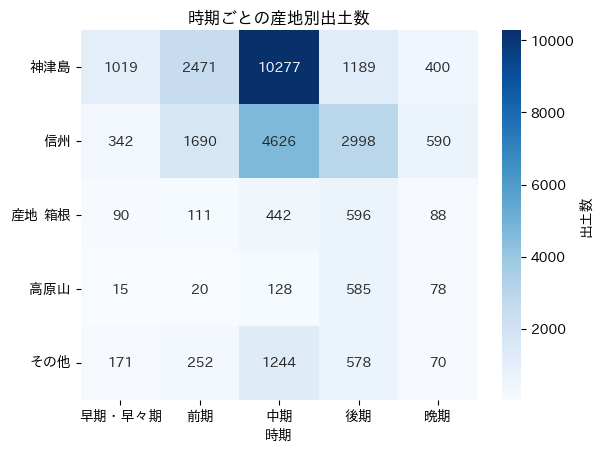

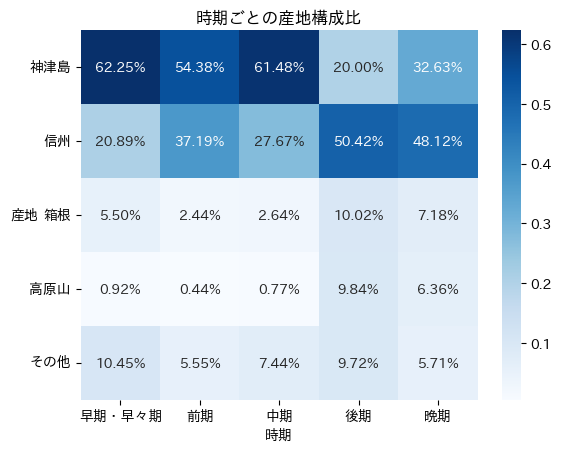

In [7]:
sns.heatmap(
    data = (
        df_result
            .group_by(["産地カテゴリ", "時期"])
            .len()
            .pivot(on="産地カテゴリ", index="時期", values="len")
            .sort("時期")
            .to_pandas()
            .set_index("時期")
            .rename(index=time_period_name)
            .reindex(columns=origin_order)
            .transpose()
    ), 
    cmap="Blues", 
    annot=True, 
    fmt="d",
    yticklabels=True, 
    cbar_kws={'label': '出土数'}
)

# y軸のラベルを水平に設定
plt.yticks(rotation=0)
plt.ylabel('産地', rotation=0, va='center', fontweight='heavy')
plt.xlabel("時期", fontweight='heavy')

plt.title("時期ごとの産地別出土数")
plt.show()

sns.heatmap(
    data = (
        df_result
            .group_by(["産地カテゴリ", "時期"])
            .len()
            .pivot(on="産地カテゴリ", index="時期", values="len")
            .sort("時期")
            .to_pandas()
            .set_index("時期")
            .rename(index=time_period_name)
            .reindex(columns=origin_order)
            .apply(lambda x: x / x.sum(), axis=1)
            .transpose()
    ), 
    cmap="Blues", 
    annot=True, 
    fmt=".2%",
    yticklabels=True,  # y軸ラベルを表示
)

# y軸のラベルを水平に設定
plt.yticks(rotation=0)
plt.ylabel('産地', rotation=0, va='center', fontweight='heavy')
plt.xlabel("時期", fontweight='heavy')

plt.title("時期ごとの産地構成比")
plt.show()

In [8]:
df_result.write_csv("../data/11_gdf_obsedian.csv")
df_sites.write_csv("../data/11_gdf_sites.csv")